# Model Fitting with Leitao Framework

## Overview

This Jupyter notebook is built upon an existing codebase licensed under the [GNU General Public License v3.0 (GPL-3.0)](https://www.gnu.org/licenses/gpl-3.0.en.html). The original code was not modified in any substantial way; we have simply added new data (SNIS and IBNET water and sewer data) specific to our use case for the model fitting using the Leitao framework.

The original repository and notebook by Leitao et al. can be found at the following link:
- Repository: [https://github.com/edugalt/scaling](https://github.com/edugalt/scaling)
- Reference: J. C. Leitao, J.M. Miotto, M. Gerlach, and E. G. Altmann, "Is this scaling nonlinear?", Royal Society Open Science 3, 150649 (2016) [DOI: 10.1098/rsos.150649](http://rsos.royalsocietypublishing.org/content/3/7/150649).
- Remove results from folder "_results" to ensure original computations (instead of reading from stored results)


## Modifications
- No significant changes were made to the core code or functionality of the notebook.
- The only modification involves the addition of new input data tailored for this specific case study. From the original work by Leitao et al., the Brazil datasets remain in the repository for exploring (brazil_externalCauses_2010, brazil_aids_2010, brazil_gdp_2010).
- The SNIS (2020) and IBNET (2015) data used in this study are placed in brazilsewer, brazilsewer_served, brazilwater, brazilwater_served, ibnetsewer, ibnetsewer_served, ibnetwater, ibnetwater_served. 

## License
This notebook continues to be licensed under the terms of the **GPL-3.0** as per the original repository's license requirements. Please refer to the original repository for any further licensing details and attributions.


In [1]:
import os
import glob
import sys
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
from matplotlib.pyplot import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sys.path.append('./scripts')
sys.path.append('./data')

import analysis_SNIS_IBNET as aSI

MIN_VALUE = 10**-8
%load_ext autoreload
%autoreload 2

def summary(func):
    print(func.description,'\t Dataset:',func.dataset)
    print('Beta +- error:\t',func.beta)
    print('P-value:\t',func.p_value)
    print('BIC:\t\t',func.bic,'\n')
    

In [2]:
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")

## Additional Functions for Manuscript Inputs
This section contains all the custom functions that have been developed in addition to the original Leitão et al. work (https://github.com/edugalt/scaling) to facilitate data processing, plotting, and analysis required to generate the results presented in this manuscript.

In [3]:
def load_colormap(dataset):
    color_info = {'brazil_sewerM': ('brazilsewerMcolor.csv', 'Served Population (inhabitants)'), 'brazil_sewerN': ('brazilsewerNcolor.csv', 'Total Population (inhabitants)'),
                'brazil_waterM': ('brazilwaterMcolor.csv', 'Served Population (inhabitants)'), 'brazil_waterN': ('brazilwaterNcolor.csv', 'Total Population (inhabitants)'),
                'ibnetsewerM': ('ibnetsewer2015Mcolor.csv', 'Served Population (inhabitants)'), 'ibnetsewerN': ('ibnetsewer2015Ncolor.csv', 'Total Population (inhabitants)'),
                'ibnetwaterM': ('ibnetwater2015Mcolor.csv', 'Served Population (inhabitants)'), 'ibnetwaterN': ('ibnetwater2015Ncolor.csv', 'Total Population (inhabitants)'),
                }
    csv_file, sort_parameter = color_info.get(dataset, (None, None))    
    if not csv_file:
        raise ValueError("Name not recognized")    
    csv_path = os.path.join('data', 'color_maps', csv_file)
    df = pd.read_csv(csv_path)
    sorted_df = df.sort_values(by=sort_parameter)
    return sorted_df['Percent Served'].tolist(), sort_parameter

def LS_bic(LS, x, y):
    residuals = np.log(y) - (np.exp(LS[2]) + LS[0] * np.log(x))
    llf = -0.5 * len(y) * (np.log(2 * np.pi) + np.log(np.var(residuals)) + 1)
    bic = -2 * llf + 2 * np.log(len(y))
    return bic

def apply_plot_style(ax, xlabel, ylabel, legend_loc='upper left'):
    # Set labels and tick parameters
    ax.set_xlabel(xlabel, fontsize=24)
    ax.set_ylabel(ylabel, fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=18) 

    # Remove the top and right spines (the box around the plot)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Keep the bottom and left spines (x and y axes)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)

    # Remove tick marks
    ax.tick_params(axis='both', which='both', length=0)

    # Add legend
    ax.legend(loc=legend_loc, fontsize=15)

# Choose the dataset 

- by setting the variable dataset="name of the dataset you want to analyze"
- Pick one of the available SNIS datasets (brazil_sewerM, brazil_sewerN, brazil_waterM, brazil_waterN) or
- Pick one of the available IBNET datasets (ibnetsewerM, ibnetsewerN, ibnetwaterM, ibnetwaterN)
- M: Served Population (inhabitants), N: Total Population (inhabitants)

In [4]:
#Pick one of the available SNIS datasets (brazil_sewerM, brazil_sewerN, brazil_waterM, brazil_waterN) or
#Pick one of the available IBNET datasets (ibnetsewerM, ibnetsewerN, ibnetwaterM, ibnetwaterN)
dataset="brazil_sewerN"
try:
    x=aSI.xy(dataset).x
    y=aSI.xy(dataset).y
except:
    print("Invalid Dataset Chosen. Available datasets are:\n")
    for i in aSI.DATABASES:
        print(i)

# Performing Analysis

 - Each line is one of the models, with specific constraints: (a) Log-normal model with free delta, δ ∈ [1, 3] and (b) Log-normal model with fixed delta, δ = 2. For additional fitting models (e.g., Gaussian model, Population model, etc.), use the original notebook (https://github.com/edugalt/scaling).
 - Further constraints cna be fixed in each model. 
 - This can take some minutes for the larger datasets
 - Increase the "required_successes=" parameter to increase precision (and computational time) 

### Log-Normal with δ ∈ [1, 3] 

In [5]:
ln = aSI.LogNormalAnalysis(dataset, required_successes=24)

### Log-Normal with δ = 2

In [6]:
ln_deltaf=aSI.LogNormalFixedDAnalysis(dataset,required_successes=24)

### Least Square Fit

In [8]:
LS=aSI.mls_best_fit(np.log(x),np.log(y))
bic = LS_bic(LS, x, y)

# Outcome of the Analysis 

### Printing the outcomes

In [9]:
print(r"Lognormal Model, free "+ chr(948) +': ' +str(ln.params[3])[:4])
summary(ln)
print(r"Lognormal Model, fixed "+ chr(948) +'(= 2): ' +str(ln_deltaf.params[3])[:4])
summary(ln_deltaf)

print("\nLeast Square fitting parameters:",LS, " and BIC: ", bic)

Lognormal Model, free δ: 2.49
Log normal fluctuations with a general \delta 	 Dataset: brazil_sewerN
Beta +- error:	 (0.875889002980388, 0.026172345304217085)
P-value:	 6.280258797133454e-56
BIC:		 27949.86444014557 

Lognormal Model, fixed δ(= 2): 2.0
Log normal fluctuations with \delta = 2 	 Dataset: brazil_sewerN
Beta +- error:	 (0.7788415226755867, 0.19552478722818134)
P-value:	 1.2830502147263558e-87
BIC:		 28274.736227381192 


Least Square fitting parameters: (0.7846714685664913, 0.02929759381370495, -4.093867893755531)  and BIC:  7946.000119203825


### Plotting and Reporting 

In [10]:
k, xlabel = load_colormap(dataset)

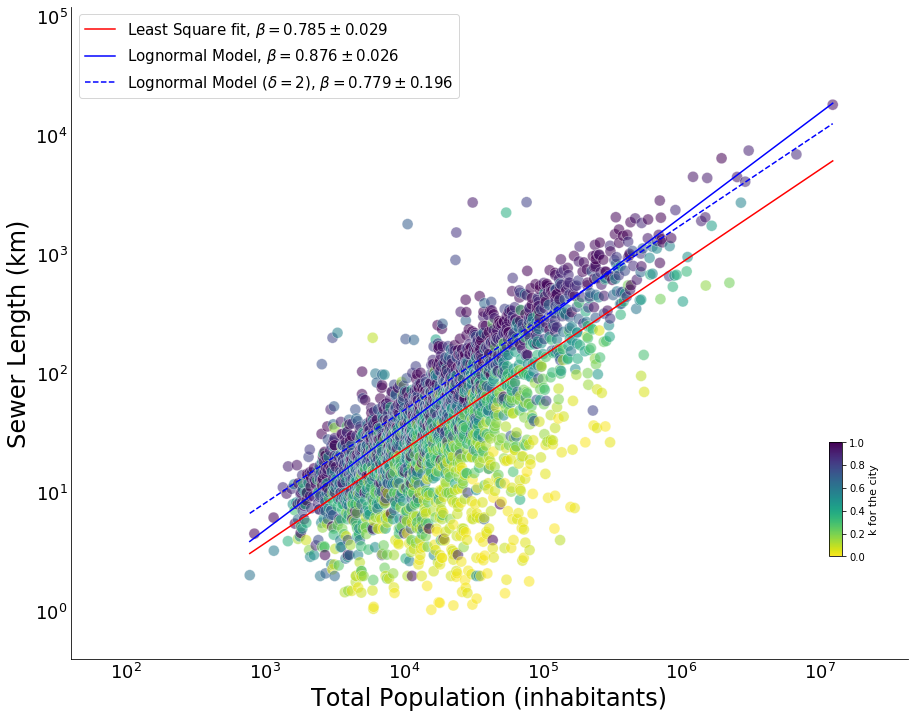

In [11]:
fig, ax = subplots(figsize=(15, 12))
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.4 * 10 ** 2, 0.43 * 10 ** 8)
ax.set_ylim(0.4 * 10 ** 0, 1.2 * 10 ** 5)
# Data scatter plot
scatter = sns.scatterplot(x=x, y=y, hue=k, palette='viridis_r', s=120, edgecolor='w', linewidth=0.5, alpha=0.55, legend = False)
# Fitted model line plots
ax.plot(x, np.exp(LS[2])*x**LS[0], "-", ms=3, color="red", label=r"Least Square fit, $\beta={:.3f} \pm {:.3f}$".format(LS[0], LS[1]))
ax.plot(x, ln.params[0]*x**ln.params[1], "-", ms=3, color="blue", label=r"Lognormal Model, $\beta={:.3f} \pm {:.3f}$".format(ln.beta[0], ln.beta[1]))
ax.plot(x, ln_deltaf.params[0]*x**ln_deltaf.params[1], "--", ms=3, color="blue", label=r"Lognormal Model ($\delta=$2), $\beta={:.3f} \pm {:.3f}$".format(ln_deltaf.beta[0], ln_deltaf.beta[1]))
ylabel = 'Sewer Length (km)' if 'sewer' in dataset.lower() else ('Water Length (km)' if 'water' in dataset.lower() else 'Y')
apply_plot_style(ax, xlabel, ylabel)

# Color bar
axin = inset_axes(ax, width="20%", height="50%", loc='lower left', bbox_to_anchor=(0.9, 0.15, 0.075, 0.35), bbox_transform=ax.transAxes)
norm = Normalize(0, 1)
sm = cm.ScalarMappable(cmap='viridis_r', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=axin)
cbar.set_label('k for the city', fontsize=11)

# Show plot
show()


## Reporting

In [12]:
# Create a dataframe to hold results
columns = ['Dataset', 'City Size', 'Model', 'Beta', 'Error', 'BIC']
results = []
#print('Analyzing dataset:  ')
# Loop through all datasets in DATABASES
for dataset_name in aSI.DATABASES.keys():
    #print(f"\t {dataset_name}")
    # Load x, y
    data = aSI.xy(dataset_name)
    x, y = data.x, data.y

    # Least Squares Fit
    LS, bic_ls = aSI.mls_best_fit(np.log(x),np.log(y)), LS_bic(LS, x, y)
    beta_ls, error_ls = LS[0], LS[1]
    results.append([dataset_name, len(x), 'Least Squares', beta_ls, error_ls, bic_ls])
    
    # Lognormal Model (δ free)
    ln = aSI.LogNormalAnalysis(dataset, required_successes=24)
    beta_ln, error_ln = ln.beta[0], ln.beta[1]
    bic_ln = ln.bic
    results.append([dataset_name, len(x),  'Lognormal Free δ', beta_ln, error_ln, bic_ln])
    
    # Lognormal Model (δ fixed = 2)
    ln_deltaf = aSI.LogNormalFixedDAnalysis(dataset,required_successes=24)
    beta_ln_fixed, error_ln_fixed = ln_deltaf.beta[0], ln_deltaf.beta[1]
    bic_ln_fixed = ln_deltaf.bic
    results.append([dataset_name, len(x), 'Lognormal δ=2', beta_ln_fixed, error_ln_fixed, bic_ln_fixed])

# Create DataFrame for the summary table
results_df = pd.DataFrame(results, columns=columns)


In [14]:
results_df.style.format({'Beta': "{:.3f}", 'Error': "{:.3f}", 'BIC': "{:.1f}"}).hide_index().set_table_styles([
        {'selector': 'th', 'props': [('font-size', '14pt')]},   
        {'selector': 'td', 'props': [('font-size', '12pt')]},   
        {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '16pt'), ('font-weight', 'bold')]}]).set_caption("Model Fitting Results")

Dataset,City Size,Model,Beta,Error,BIC
brazil_sewerN,2755,Least Squares,0.785,0.029,7946.0
brazil_sewerN,2755,Lognormal Free δ,0.876,0.026,27949.9
brazil_sewerN,2755,Lognormal δ=2,0.779,0.196,28274.7
brazil_sewerM,2755,Least Squares,0.842,0.016,5532.2
brazil_sewerM,2755,Lognormal Free δ,0.876,0.026,27949.9
brazil_sewerM,2755,Lognormal δ=2,0.779,0.196,28274.7
brazil_waterN,2689,Least Squares,0.911,0.018,5083.8
brazil_waterN,2689,Lognormal Free δ,0.876,0.026,27949.9
brazil_waterN,2689,Lognormal δ=2,0.779,0.196,28274.7
brazil_waterM,2689,Least Squares,0.873,0.014,4069.6
